# Introduction

<table>
  <tr><td>
    <img src="https://pas-wordpress-media.s3.us-east-1.amazonaws.com/content/uploads/2015/12/loan-e1450497559334.jpg"
         width="400" height="600">
      <tr><td align="center">
  </td></tr>
  </td></tr>
</table>

In finance, a loan is the lending of money by one or more individuals, organizations, or other entities to other individuals, organizations etc. The recipient (i.e., the borrower) incurs a debt and is usually liable to pay interest on that debt until it is repaid as well as to repay the principal amount borrowed. ([wikipedia](https://en.wikipedia.org/wiki/Loan))

### **The major aim of this notebook is to predict which of the customers will have their loan approved.**

![](https://i.pinimg.com/originals/41/b0/08/41b008395e8e7f888666688915750d1f.gif)

# Data Id 📋

This dataset is named [Loan Prediction Dataset](https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset) data set. The dataset contains a set of **613** records under **13 attributes**:

![](http://miro.medium.com/max/795/1*cAd_tqzgCWtCVMjEasWmpQ.png)

## The main objective for this dataset:
Using machine learning techniques to predict loan payments.

### target value: `Loan_Status`

# Libraries 📕📗📘

In [35]:
import os #paths to file
import numpy as np # linear algebra
import pandas as pd # data processing
import warnings# warning filter


#ploting libraries
import matplotlib.pyplot as plt 
import seaborn as sns

#relevant ML libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#ML models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#default theme
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

#warning hadle
warnings.filterwarnings("ignore")

In [36]:
# read in csv file as a DataFrame
data = pd.read_csv('/content/sample_data/loan_data.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Testing set:

Size of each data set:

In [37]:
print(f"training set (row, col): {data.shape}")

training set (row, col): (614, 13)


### Now the focus is shifted for the preprocessing of the training dataset.

In [38]:
#column information
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [39]:
#summary statistics
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [40]:
#the Id column is not needed, let's drop it for both test and train datasets
data.drop('Loan_ID',axis=1,inplace=True)
#checking the new shapes
print(f"training set (row, col): {data.shape}")

training set (row, col): (614, 12)


## Missing values 🚫
As you can see we have some missing data, let's have a look how many we have for each column:

In [41]:
#missing values in decsending order
data.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

Each value will be replaced by the most frequent value (mode).

E.G. `Credit_History` has 50 null values and has 2 unique values `1.0` (475 times) or `0.0` (89 times) therefore each null value will be replaced by the mode `1.0` so now it will show in our data 525 times. 

In [42]:
#filling the missing data
print("Before filling missing values\n\n","#"*50,"\n")
null_cols = ['Credit_History', 'Self_Employed', 'LoanAmount','Dependents', 'Loan_Amount_Term', 'Gender', 'Married']


for col in null_cols:
    print(f"{col}:\n{data[col].value_counts()}\n","-"*50)
    data[col] = data[col].fillna(
    data[col].dropna().mode().values[0] )   

    
data.isnull().sum().sort_values(ascending=False)
print("After filling missing values\n\n","#"*50,"\n")
for col in null_cols:
    print(f"\n{col}:\n{data[col].value_counts()}\n","-"*50)

Before filling missing values

 ################################################## 

Credit_History:
1.0    475
0.0     89
Name: Credit_History, dtype: int64
 --------------------------------------------------
Self_Employed:
No     500
Yes     82
Name: Self_Employed, dtype: int64
 --------------------------------------------------
LoanAmount:
120.0    20
110.0    17
100.0    15
160.0    12
187.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: LoanAmount, Length: 203, dtype: int64
 --------------------------------------------------
Dependents:
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
 --------------------------------------------------
Loan_Amount_Term:
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64
 --------------------------------------------------
Gender:
Male      489
Female    112
Name: Gender, dtype

## Data visalization 📊

Firstly we need to split our data to categorical and numerical data,


using the `.select_dtypes('dtype').columns.to_list()` combination.

## Loan status distribution

In [43]:
#list of all the columns.columns
#Cols = tr_df.tolist()
#list of all the numeric columns
num = data.select_dtypes('number').columns.to_list()
#list of all the categoric columns
cat = data.select_dtypes('object').columns.to_list()

#numeric df
loan_num =  data[num]
#categoric df
loan_cat = data[cat]

Let's plot our data

Numeric:

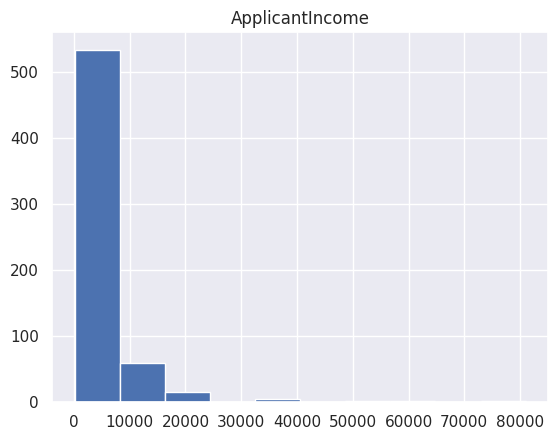

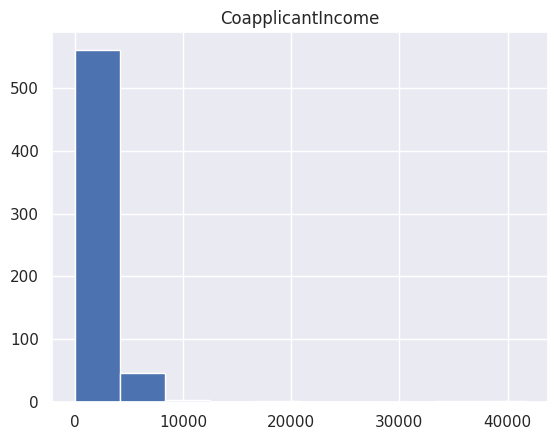

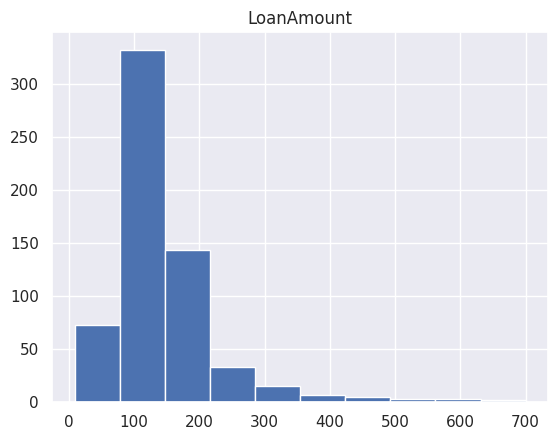

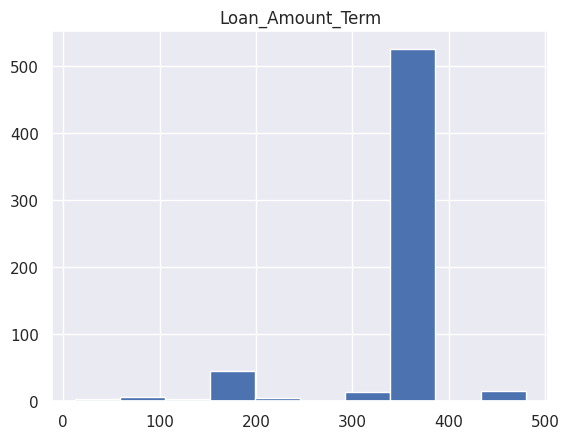

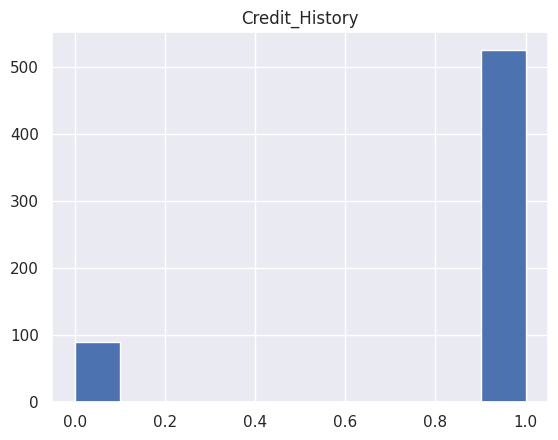

In [44]:
for i in loan_num:
    plt.hist(loan_num[i])
    plt.title(i)
    plt.show()


Categorical (split by Loan status):

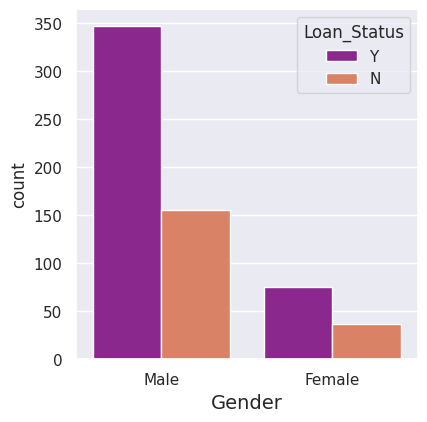

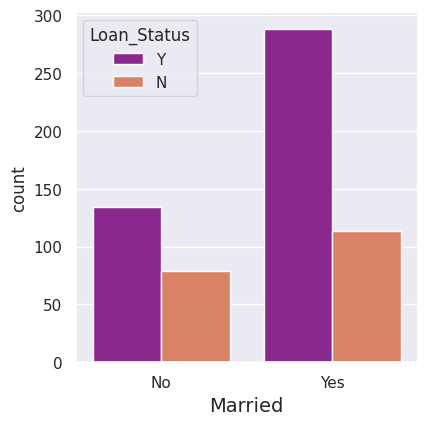

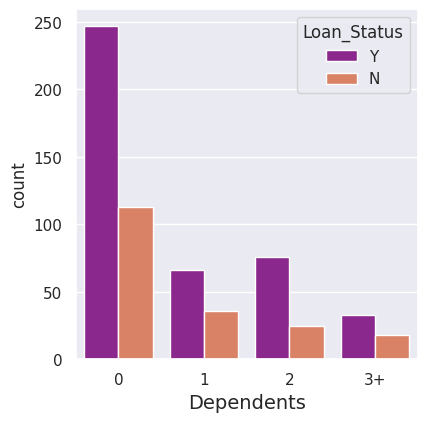

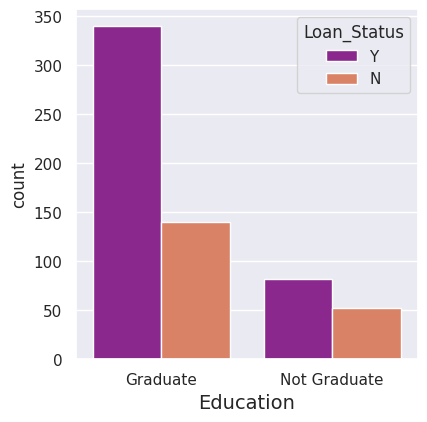

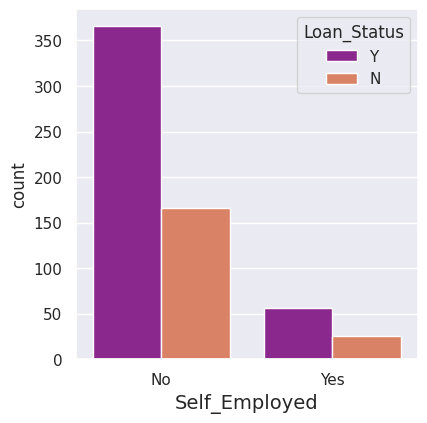

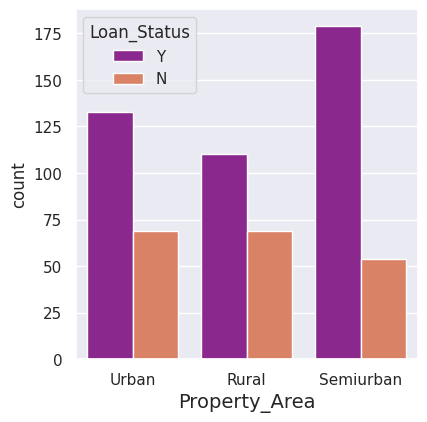

In [45]:
for i in cat[:-1]: 
    plt.figure(figsize=(15,10))
    plt.subplot(2,3,1)
    sns.countplot(x=i ,hue='Loan_Status', data=data ,palette='plasma')
    plt.xlabel(i, fontsize=14)

## Encoding data to numeric

In [46]:
#converting categorical values to numbers

to_numeric = {'Male': 1, 'Female': 2,
'Yes': 1, 'No': 2,
'Graduate': 1, 'Not Graduate': 2,
'Urban': 3, 'Semiurban': 2,'Rural': 1,
'Y': 1, 'N': 0,
'3+': 3}

# adding the new numeric values from the to_numeric variable to both datasets
tr_df = data.applymap(lambda lable: to_numeric.get(lable) if lable in to_numeric else lable)

# convertind the Dependents column
Dependents_ = pd.to_numeric(tr_df.Dependents)


# dropping the previous Dependents column
tr_df.drop(['Dependents'], axis = 1, inplace = True)

# concatination of the new Dependents column with both datasets
tr_df = pd.concat([tr_df, Dependents_], axis = 1)


# checking the our manipulated dataset for validation
print(f"training set (row, col): {data.shape}")
print(tr_df.info())

training set (row, col): (614, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Education          614 non-null    int64  
 3   Self_Employed      614 non-null    int64  
 4   ApplicantIncome    614 non-null    int64  
 5   CoapplicantIncome  614 non-null    float64
 6   LoanAmount         614 non-null    float64
 7   Loan_Amount_Term   614 non-null    float64
 8   Credit_History     614 non-null    float64
 9   Property_Area      614 non-null    int64  
 10  Loan_Status        614 non-null    int64  
 11  Dependents         614 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 57.7 KB
None


## Correlation matrix 

<Axes: >

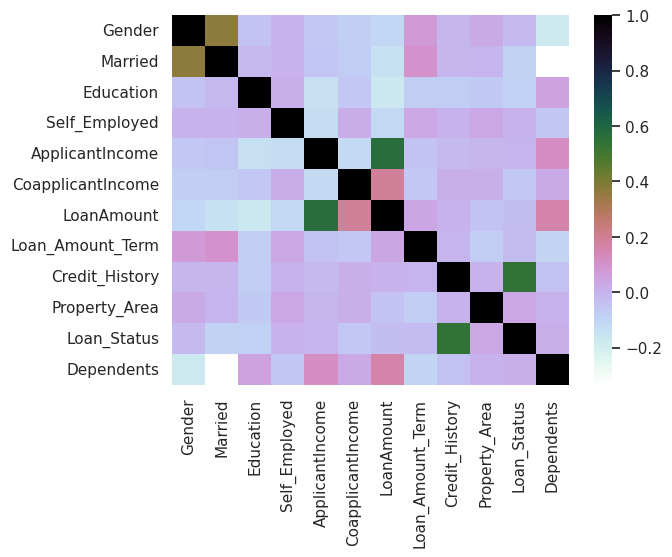

In [47]:
#plotting the correlation matrix
sns.heatmap(tr_df.corr() ,cmap='cubehelix_r')

### Correlation table for a more detailed analysis:

In [48]:
#correlation table
corr = tr_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Dependents
Gender,1.00,0.36,-0.05,-0.00,-0.06,-0.08,-0.11,0.07,-0.01,0.03,-0.02,-0.17
Married,0.36,1.00,-0.01,0.00,-0.05,-0.08,-0.15,0.10,-0.01,-0.00,-0.09,-0.33
Education,-0.05,-0.01,1.00,0.01,-0.14,-0.06,-0.17,-0.07,-0.07,-0.07,-0.09,0.06
Self_Employed,-0.00,0.00,0.01,1.00,-0.13,0.02,-0.11,0.03,0.00,0.03,0.00,-0.06
ApplicantIncome,-0.06,-0.05,-0.14,-0.13,1.00,-0.12,0.56,-0.05,-0.02,-0.01,-0.00,0.12
CoapplicantIncome,-0.08,-0.08,-0.06,0.02,-0.12,1.00,0.19,-0.06,0.01,0.01,-0.06,0.03
LoanAmount,-0.11,-0.15,-0.17,-0.11,0.56,0.19,1.00,0.04,-0.00,-0.05,-0.03,0.16
Loan_Amount_Term,0.07,0.10,-0.07,0.03,-0.05,-0.06,0.04,1.00,-0.00,-0.08,-0.02,-0.10
Credit_History,-0.01,-0.01,-0.07,0.00,-0.02,0.01,-0.00,-0.00,1.00,0.00,0.54,-0.04
Property_Area,0.03,-0.00,-0.07,0.03,-0.01,0.01,-0.05,-0.08,0.00,1.00,0.03,-0.00


We can clearly see that `Credit_History` has the highest correlation with `Loan_Status` (a positive correlation of `0.54`).
Therefore our target value is highly dependant on this column.

# Machine learning models

First of all we will divide our dataset into two variables `X` as the features we defined earlier and `y` as the `Loan_Status` the target value we want to predict.

## Models we will use:

* **Decision Tree** 
* **Random Forest**
* **XGBoost**
* **Logistic Regression**

## The Process of Modeling the Data:

1. Importing the model

2. Fitting the model

3. Predicting Loan Status

4. Classification report by Loan Status

5. Overall accuracy


In [49]:
y = tr_df['Loan_Status']
X = tr_df.drop('Loan_Status', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Decision Tree

![](https://i.pinimg.com/originals/eb/08/05/eb0805eb6e34bf3eac5ab4666bbcc167.gif)

In [50]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

y_predict = DT.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
DT_SC = accuracy_score(y_predict,y_test)
print(f"{round(DT_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.46      0.51      0.49        51
           1       0.81      0.78      0.79       134

    accuracy                           0.70       185
   macro avg       0.64      0.64      0.64       185
weighted avg       0.71      0.70      0.71       185

70.27% Accurate


In [51]:
Decision_Tree=pd.DataFrame({'y_test':y_test,'prediction':y_predict})
Decision_Tree.to_csv("Dection Tree.csv")     

## Random Forest

![](https://miro.medium.com/max/1280/1*9kACduxnce_JdTrftM_bsA.gif)

In [52]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

y_predict = RF.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
RF_SC = accuracy_score(y_predict,y_test)
print(f"{round(RF_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.68      0.41      0.51        51
           1       0.81      0.93      0.86       134

    accuracy                           0.78       185
   macro avg       0.74      0.67      0.69       185
weighted avg       0.77      0.78      0.76       185

78.38% Accurate


In [53]:
Random_Forest=pd.DataFrame({'y_test':y_test,'prediction':y_predict})
Random_Forest.to_csv("Random Forest.csv")     

## XGBoost

![](https://f-origin.hypotheses.org/wp-content/blogs.dir/253/files/2015/06/boosting-algo-3.gif)

In [54]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

y_predict = XGB.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
XGB_SC = accuracy_score(y_predict,y_test)
print(f"{round(XGB_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.65      0.55      0.60        51
           1       0.84      0.89      0.86       134

    accuracy                           0.79       185
   macro avg       0.74      0.72      0.73       185
weighted avg       0.79      0.79      0.79       185

79.46% Accurate


In [55]:
XGBoost=pd.DataFrame({'y_test':y_test,'prediction':y_predict})
XGBoost.to_csv("XGBoost.csv")     

## Logistic Regression
Now, I will explore the Logistic Regression model.

<table>
  <tr><td>
    <img src="https://files.realpython.com/media/log-reg-2.e88a21607ba3.png"
          width="500" height="400">
      <tr><td align="center">
  </td></tr>
  </td></tr>
</table>

In [56]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

y_predict = LR.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
LR_SC = accuracy_score(y_predict,y_test)
print('accuracy is',accuracy_score(y_predict,y_test))

              precision    recall  f1-score   support

           0       0.92      0.43      0.59        51
           1       0.82      0.99      0.89       134

    accuracy                           0.83       185
   macro avg       0.87      0.71      0.74       185
weighted avg       0.85      0.83      0.81       185

accuracy is 0.8324324324324325


In [59]:
Logistic_Regression=pd.DataFrame({'y_test':y_test,'prediction':y_predict})
Logistic_Regression.to_csv("Logistic Regression.csv")     

# Conclusion

1. `Credit_History` is a very important variable  because of its high correlation with `Loan_Status` therefor showind high Dependancy for the latter.
2. The Logistic Regression algorithm is the most accurate: **approximately 83%**.

In [60]:
score = [DT_SC,RF_SC,XGB_SC,LR_SC]
Models = pd.DataFrame({
    'n_neighbors': ["Decision Tree","Random Forest","XGBoost", "Logistic Regression"],
    'Score': score})
Models.sort_values(by='Score', ascending=False)

,n_neighbors,Score
3,Logistic Regression,0.832432
2,XGBoost,0.794595
1,Random Forest,0.783784
0,Decision Tree,0.702703


In [61]:
print(X)

     Gender  Married  Education  Self_Employed  ApplicantIncome  \
0         1        2          1              2             5849   
1         1        1          1              2             4583   
2         1        1          1              1             3000   
3         1        1          2              2             2583   
4         1        2          1              2             6000   
..      ...      ...        ...            ...              ...   
609       2        2          1              2             2900   
610       1        1          1              2             4106   
611       1        1          1              2             8072   
612       1        1          1              2             7583   
613       2        2          1              1             4583   

     CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                  0.0       120.0             360.0             1.0   
1               1508.0       128.0             360.

In [74]:
# Make predictions on new data
# Load the data
data = pd.DataFrame({
    'Gender': [1],
    'Married': [2],
    'Education': [1],
    'Self_Employed': [2],
    'ApplicantIncome': [19],
    'CoapplicantIncome': [0.0],
    'LoanAmount': [120.0],
    'Loan_Amount_Term': [360.0],
    'Credit_History': [1],
    'Property_Area': [3],
    'Dependents': [0]
})

prediction = LR.predict(data)

In [75]:
# Convert predictions to human-readable labels
loan_status_labels = {
    0: 'Not Approved',
    1: 'Approved'
}
predicted_loan_status = loan_status_labels[prediction[0]]

# Display the predicted loan status
print("Predicted Loan Status:", predicted_loan_status)

Predicted Loan Status: Approved
